# Project : German Credit Risk Analysis

In [37]:
# Install ucimlrepo if it is not already installed
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


### Import required libraries

In [38]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

### Gather and Structure the Data

In [39]:
# Load dataset (German Credit Data from UCI)
statlog_data = fetch_ucirepo(id=144)
X = statlog_data.data.features
y = statlog_data.data.targets

In [40]:
# Rename columns based on UCI documentation
X.columns = [
    "Status_checking_account", "Duration_month", "Credit_history", "Purpose",
    "Credit_amount", "Savings_account", "Employment_since", "Installment_rate",
    "Personal_status_sex", "Other_debtors_guarantors", "Residence_since",
    "Property", "Age_years", "Other_installment_plans", "Housing",
    "Existing_credits", "Job", "Num_liable", "Telephone", "Foreign_worker"
]

# Convert target: 1 = good credit, 2 = bad credit
y = y.replace({1: "Good", 2: "Bad"})
y = y.rename(columns={y.columns[0]: "Credit_risk"})

# Combine features and target
df = pd.concat([X, y], axis=1)

### 1. Descriptive Analysis

#### 1.1 Univariate Visualisation

In [41]:
print("Dataset overview")
print(df.head(), "\n")
print("Shape:", df.shape, "\n")
print("Data types:\n", df.dtypes, "\n")
print("Target distribution:\n", df["Credit_risk"].value_counts(), "\n")
print("Numeric summary:\n", df.describe(), "\n")

Dataset overview
  Status_checking_account  Duration_month Credit_history Purpose  \
0                     A11               6            A34     A43   
1                     A12              48            A32     A43   
2                     A14              12            A34     A46   
3                     A11              42            A32     A42   
4                     A11              24            A33     A40   

   Credit_amount Savings_account Employment_since  Installment_rate  \
0           1169             A65              A75                 4   
1           5951             A61              A73                 2   
2           2096             A61              A74                 2   
3           7882             A61              A74                 2   
4           4870             A61              A73                 3   

  Personal_status_sex Other_debtors_guarantors  ...  Property Age_years  \
0                 A93                     A101  ...      A121        67 

The dataset contains 1,000 observations and 21 columns (20 features + 1 target).

There are no missing values, meaning the dataset is clean and ready for preprocessing.



Identify numerical and categorical features

In [42]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical features:", numeric_cols)
print("Categorical features:", categorical_cols)

Numerical features: ['Duration_month', 'Credit_amount', 'Installment_rate', 'Residence_since', 'Age_years', 'Existing_credits', 'Num_liable']
Categorical features: ['Status_checking_account', 'Credit_history', 'Purpose', 'Savings_account', 'Employment_since', 'Personal_status_sex', 'Other_debtors_guarantors', 'Property', 'Other_installment_plans', 'Housing', 'Job', 'Telephone', 'Foreign_worker', 'Credit_risk']


Histograms for numerical variables

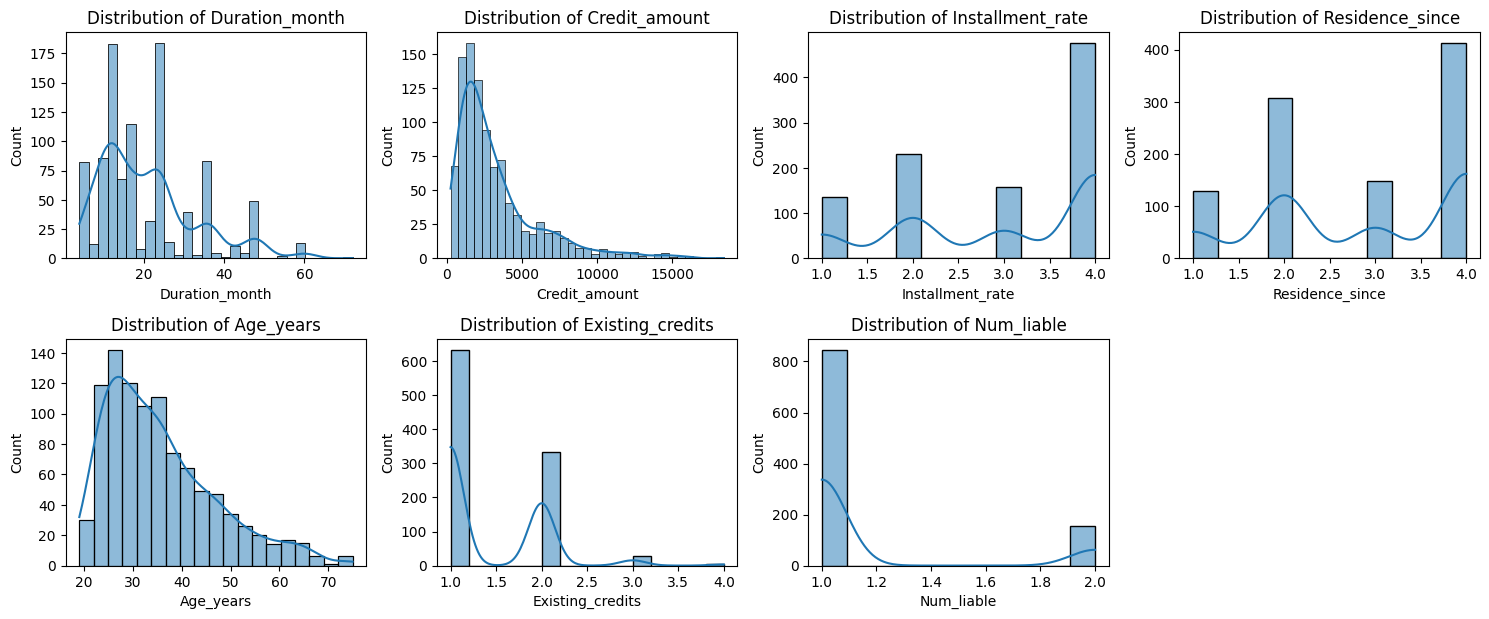

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

Boxplots for numerical variables (outlier detection)

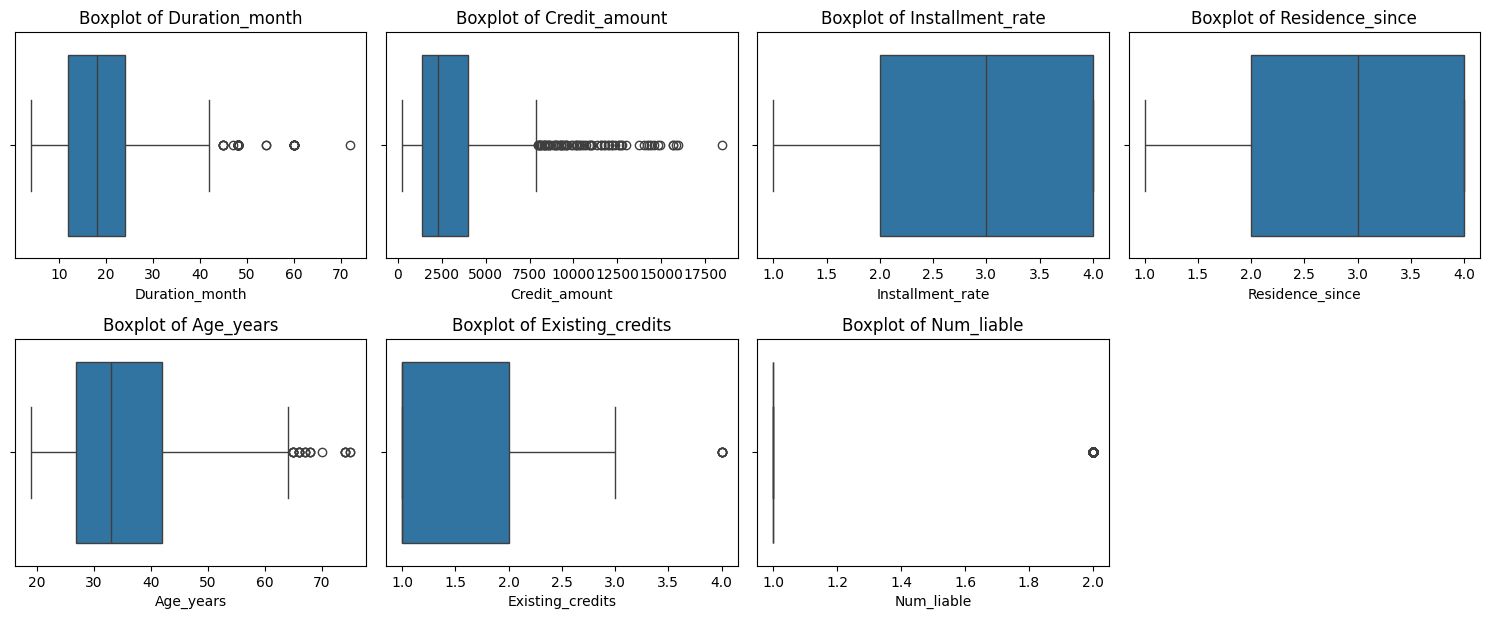

In [44]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

Barplots for categorical variables

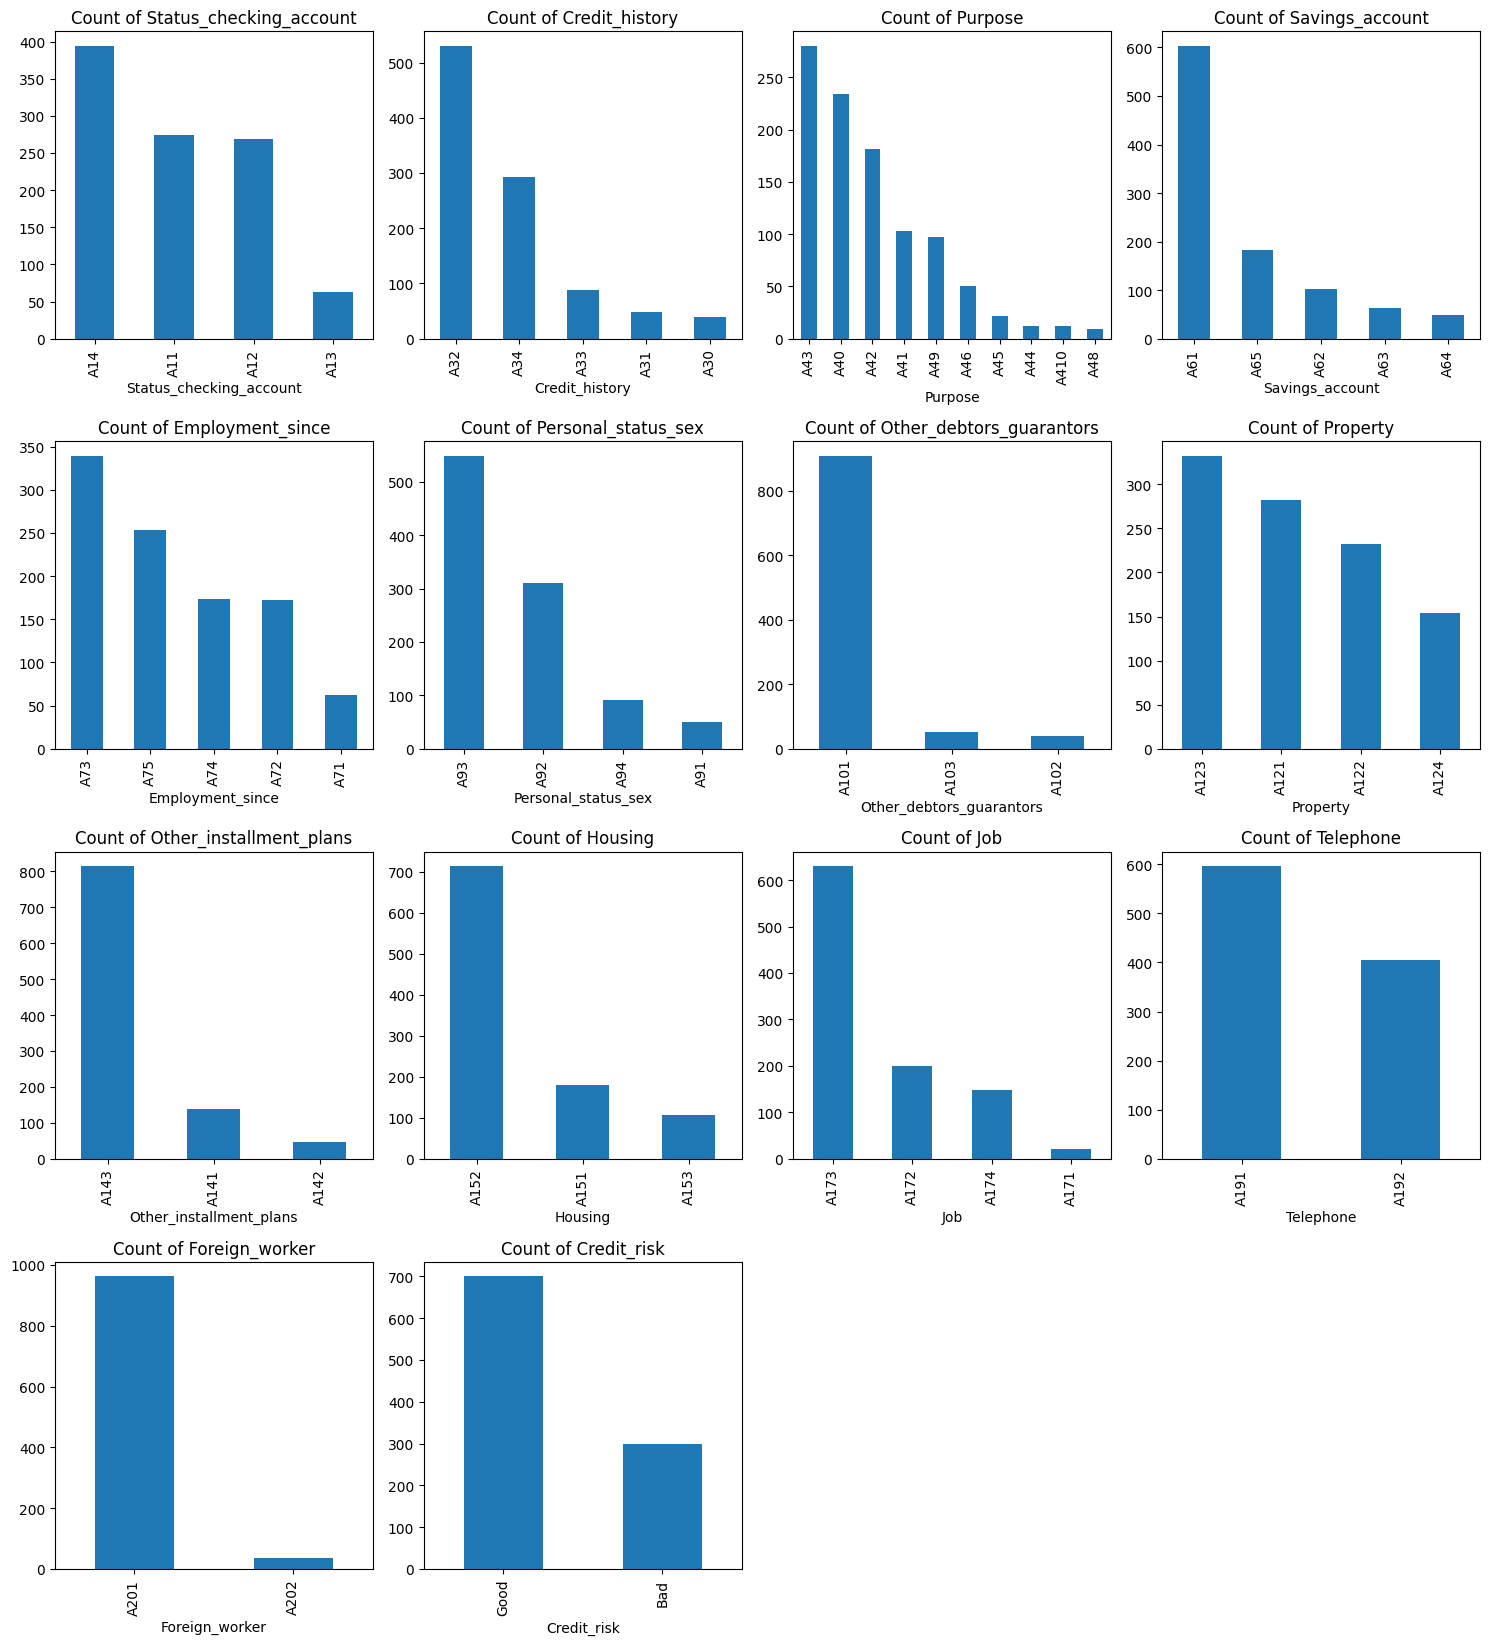

In [45]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(categorical_cols):
    plt.subplot(5, 4, i+1)
    df[col].value_counts().plot(kind='bar')
    plt.title(f"Count of {col}")
plt.tight_layout()
plt.show()

Target distribution (Credit_risk)

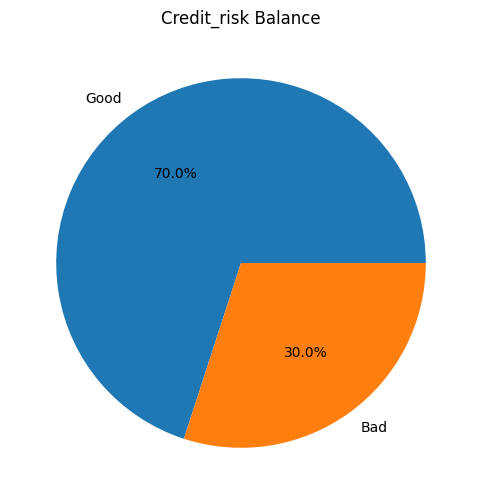

In [46]:
plt.figure(figsize=(6, 6))
df["Credit_risk"].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Credit_risk Balance")
plt.ylabel("")
plt.show()

Summary

The dataset contains skewed financial variables, categorical variables dominated by a few classes, and a clear imbalance in the target.

Outliers appear meaningful and should be preserved.

Feature scaling and proper categorical encoding will be essential.

The class imbalance motivates the use of balanced metrics and potentially resampling techniques during model training.

#### 1.2 Correlation Analysis

Correlation matrix (numerical features)

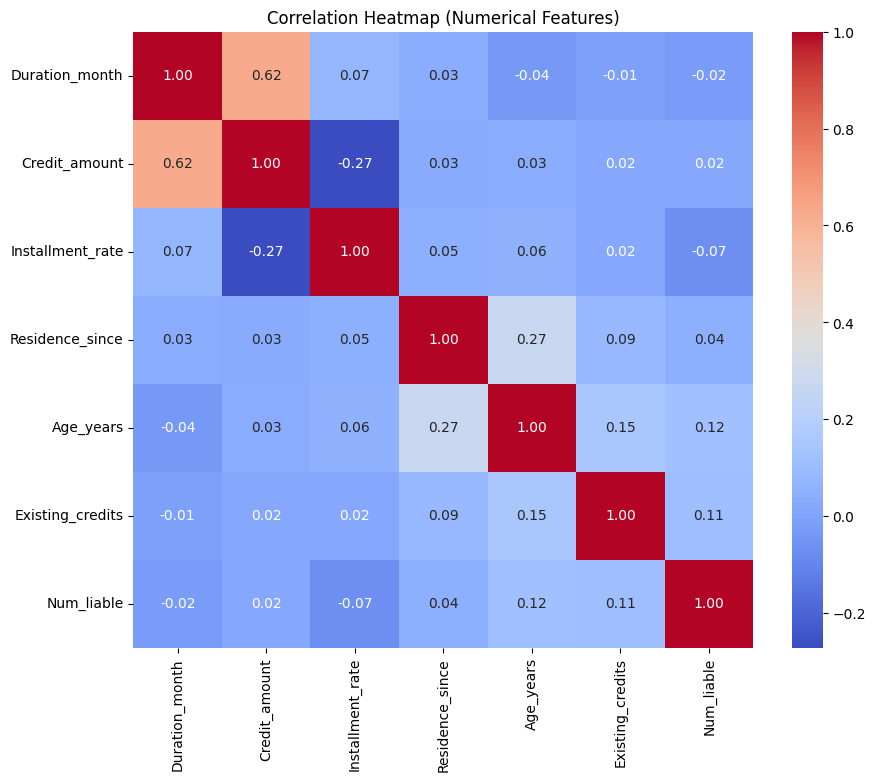

In [47]:
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

Pairplot of numerical variables

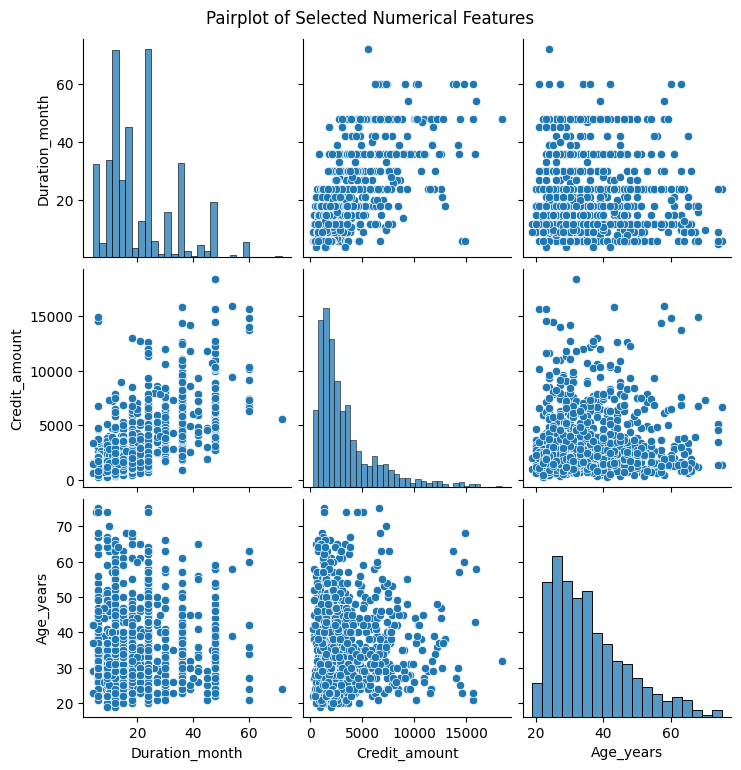

In [48]:
# Selecting a subset of numerical features for clarity
pairplot_cols = ["Duration_month", "Credit_amount", "Age_years"]

sns.pairplot(df[pairplot_cols])
plt.suptitle("Pairplot of Selected Numerical Features", y=1.02)
plt.show()

Correlation with target

In [49]:
# Encode the target
df_corr = df.copy()
df_corr["Credit_risk_encoded"] = df_corr["Credit_risk"].map({"Good": 0, "Bad": 1})

# Keep only numerical features + encoded target
num_for_corr = df_corr.select_dtypes(include=['int64', 'float64'])

# Compute correlation with the encoded target
target_corr = num_for_corr.corr()["Credit_risk_encoded"].sort_values(ascending=False)

print("Correlation of numerical features with Credit_risk:")
print(target_corr)


Correlation of numerical features with Credit_risk:
Credit_risk_encoded    1.000000
Duration_month         0.214927
Credit_amount          0.154739
Installment_rate       0.072404
Residence_since        0.002967
Num_liable            -0.003015
Existing_credits      -0.045732
Age_years             -0.091127
Name: Credit_risk_encoded, dtype: float64


Barplot of top correlations with the target

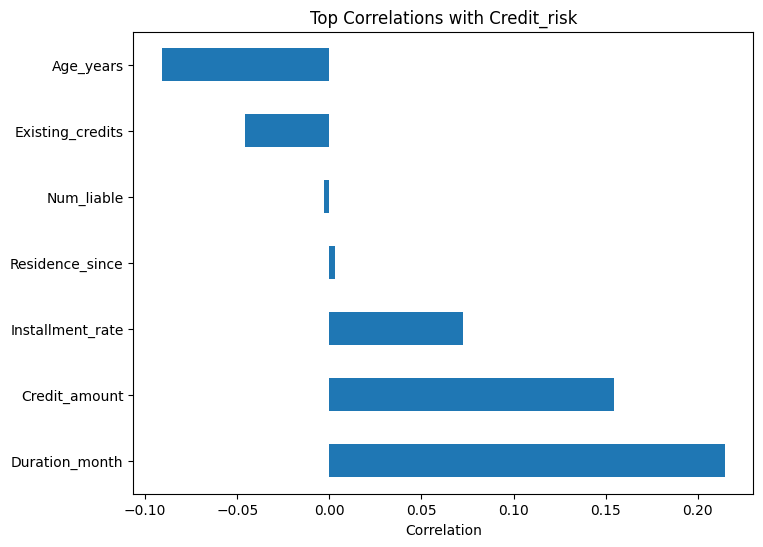

In [50]:
plt.figure(figsize=(8, 6))
target_corr.drop("Credit_risk_encoded").head(10).plot(kind='barh')
plt.title("Top Correlations with Credit_risk")
plt.xlabel("Correlation")
plt.show()

The dataset displays low linear correlations, both between numerical features and with the target.

This suggests that:

Linear models may perform poorly alone, unless combined with polynomial/higher-order interactions.

Tree-based models (Random Forest, Gradient Boosting, XGBoost) are likely more effective.

Categorical variables, once encoded, will carry most of the predictive power, since numerical variables provide only weak signals.

#### 1.3 Categorical features and target

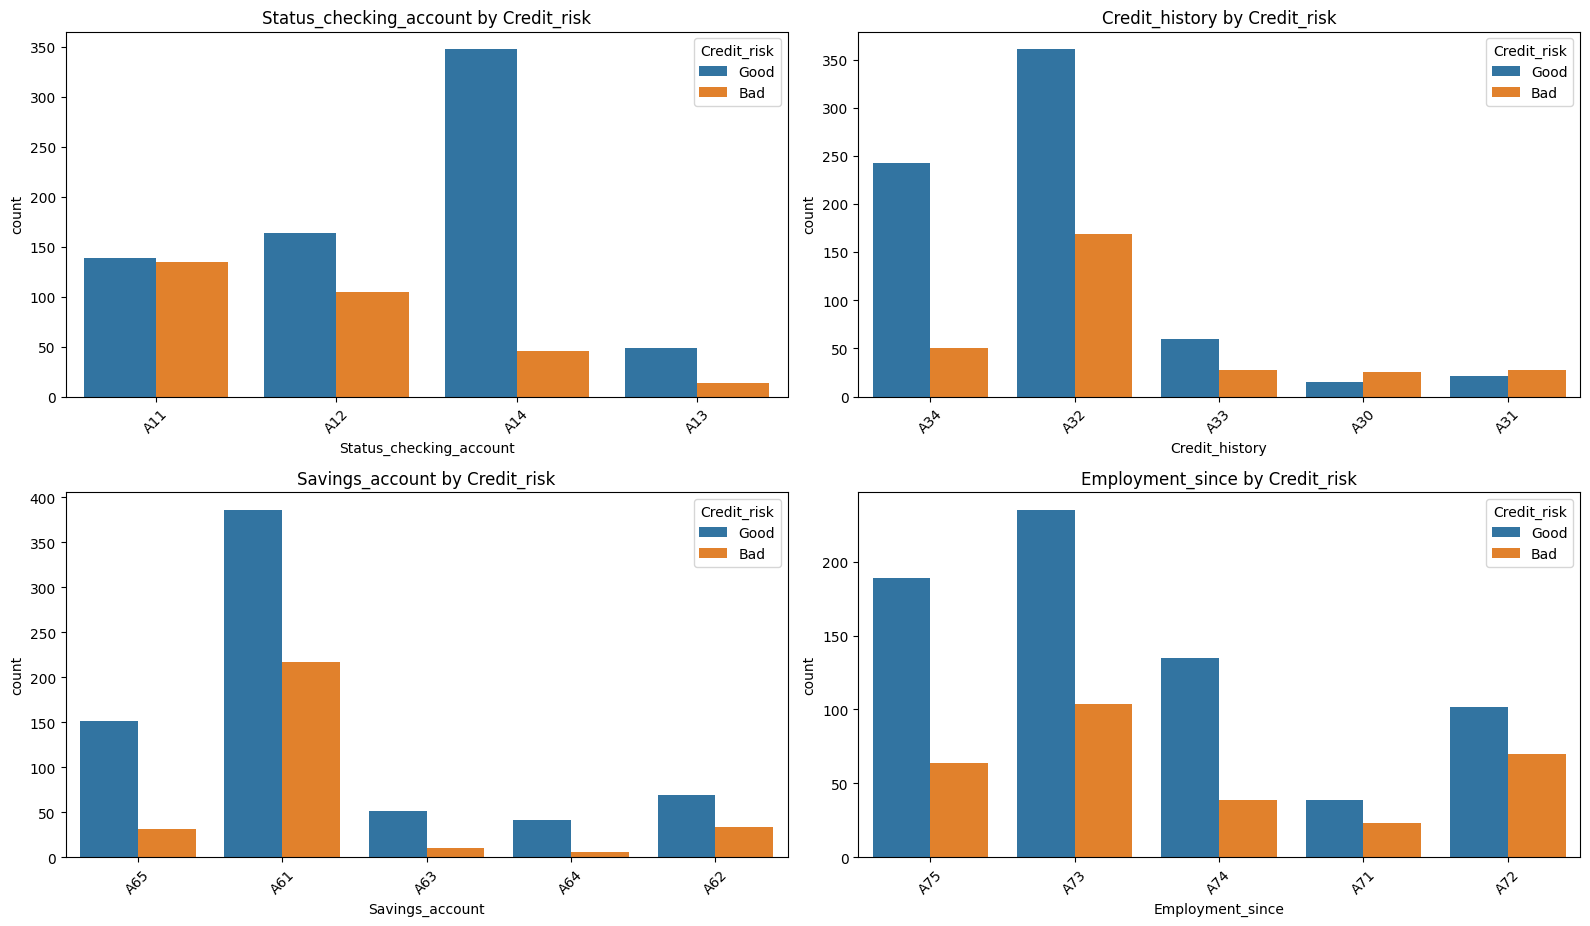

In [51]:
# Key categorical features to compare with the target
cat_for_target = [
    "Status_checking_account",
    "Credit_history",
    "Savings_account",
    "Employment_since"
]

plt.figure(figsize=(16, 18))
for i, col in enumerate(cat_for_target, 1):
    plt.subplot(4, 2, i)
    sns.countplot(data=df, x=col, hue="Credit_risk")
    plt.title(f"{col} by Credit_risk")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Clients with :<br>
strong financial history (A34, high savings),<br>
stable employment (A73, A75),<br>
positive account status (A14)<br>
have Good credit risk.<br>

Clients with<br>
weak credit history (A30, A31),<br>
no savings (A61),<br>
short employment duration (A71),<br>
less favorable account status (A11, A12),<br>
show a significantly higher chance of being Bad credit risk.

#### 1.4 Relation features and target

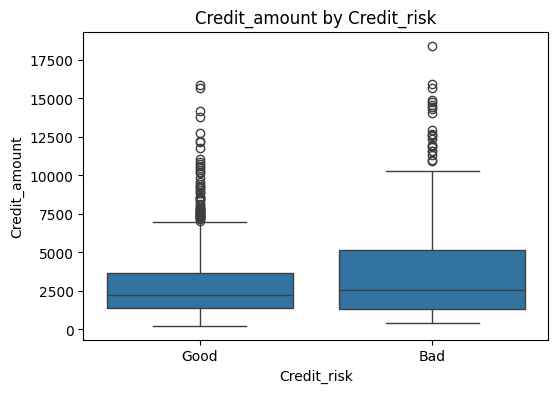

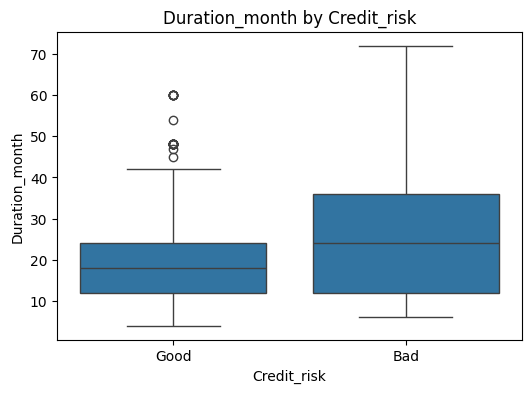

In [52]:
# Boxplot: Credit_amount by Credit_risk
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="Credit_risk", y="Credit_amount")
plt.title("Credit_amount by Credit_risk")
plt.show()

# Boxplot: Duration_month by Credit_risk
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="Credit_risk", y="Duration_month")
plt.title("Duration_month by Credit_risk")
plt.show()


Both Credit_amount and Duration_month show clear separation between Good and Bad clients.
They are strong features that should help the model differentiate between low-risk and high-risk customers.

#### 2. Data Pre-processing

In this section, we check the dataset quality before encoding and scaling.
We verify the presence of missing values, duplicates, potential outliers, and general consistency of the dataset.


In [53]:
# Checking for missing values
print("Missing values per column:")
print(df.isna().sum())

print("\nTotal missing values in the dataset:", df.isna().sum().sum())

# Checking for duplicated rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicated rows: {num_duplicates}")



Missing values per column:
Status_checking_account     0
Duration_month              0
Credit_history              0
Purpose                     0
Credit_amount               0
Savings_account             0
Employment_since            0
Installment_rate            0
Personal_status_sex         0
Other_debtors_guarantors    0
Residence_since             0
Property                    0
Age_years                   0
Other_installment_plans     0
Housing                     0
Existing_credits            0
Job                         0
Num_liable                  0
Telephone                   0
Foreign_worker              0
Credit_risk                 0
dtype: int64

Total missing values in the dataset: 0
Number of duplicated rows: 0


We can see that there are no missing or duplicated values

We define maps for the ordinal categories in order to keep the order and be more precise in the analysis

In [54]:
# Status_checking_account mapping
status_checking_account_map = {
    "A11": 0,  # < 0 DM
    "A12": 1,  # 0 < 200 DM
    "A13": 2,  # > 200 DM
    "A14": 3   # no checking account
}

# Savings_account mapping
savings_account_map = {
    "A61": 0,  # < 100 DM
    "A62": 1,  # 100–500 DM
    "A63": 2,  # 500–1000 DM
    "A64": 3,  # > 1000 DM
    "A65": 4   # unknown
}

# Employment_since mapping
employment_since_map = {
    "A71": 0,  # unemployed
    "A72": 1,  # < 1 year
    "A73": 2,  # 1–4 years
    "A74": 3,  # 4–7 years
    "A75": 4   # > 7 years
}

# Credit_history mapping
credit_history_map = {
    "A30": 0,  # no credits
    "A31": 1,  # all paid
    "A32": 2,  # existing credits paid
    "A33": 3,  # delay in past
    "A34": 4   # critical account
}

Now we replace the categorical values by the numerical ones

In [55]:
df["Employment_since"] = df["Employment_since"].map(employment_since_map)
df["Savings_account"] = df["Savings_account"].map(savings_account_map)
df["Credit_history"] = df["Credit_history"].map(credit_history_map)
df["Status_checking_account"] = df["Status_checking_account"].map(status_checking_account_map)

We check if there are NaN values after the replacement

In [56]:
df[[
    "Employment_since",
    "Savings_account",
    "Credit_history",
    "Status_checking_account"
]].isna().sum()


Employment_since           0
Savings_account            0
Credit_history             0
Status_checking_account    0
dtype: int64

In [57]:
# Separate features and target
X = df.drop("Credit_risk", axis=1)
y = df["Credit_risk"].map({"Good": 1, "Bad": 0})

# Identify categorical (nominal) columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Train-test split (BEFORE scaling)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Standardize features (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3. Problem formalization

Project Objective

The objective of this project is to predict the credit risk of individual clients using their financial and personal characteristics. This task is central to credit scoring systems, where accurate risk assessment is crucial to minimize financial losses while ensuring fair access to credit.<br>
Each observation in the dataset represents a single customer, described by 20 input features capturing various aspects of their financial situation and socio-economic profile, including:<br>

-checking account status<br>
-credit history<br>
-loan purpose<br>
-employment duration<br>
-savings and housing status<br>
-age and personal characteristics<br>

These features consist of a mixture of numerical and categorical variables, requiring careful preprocessing and encoding before model training.

Target Variable

The target variable, Credit_risk, is binary and takes the following values:<br>
Good : Low credit risk (the customer is likely to repay the loan)<br>
Bad : High credit risk (the customer is more likely to default)<br>
As a result, this problem is formulated as a supervised learning task, specifically a binary classification problem.

Learning Task Definition

Inputs (features): 20 independent variables (categorical and numerical)<br>
Output (target): Binary class label (Good / Bad)<br>
Learning type: Supervised classification

Evaluation Strategy

The dataset exhibits a moderate class imbalance, with fewer high-risk (“Bad”) customers compared to low-risk (“Good”) ones. Consequently, relying solely on accuracy could be misleading.<br>
To obtain a more reliable and informative evaluation, multiple performance metrics are considered:<br>
Accuracy to assess overall predictive performance<br>
Precision to evaluate the reliability of predicted defaults<br>
Recall, particularly for the Bad class, to measure the model’s ability to correctly identify risky clients<br>
F1-score as a balanced metric combining precision and recall

Special attention is given to recall for high-risk customers, as misclassifying a bad payer as low risk can have significant financial consequences.

### 4. Selection of a Baseline Model and Implementation

At this stage, we aim to establish a baseline model.

Given that our problem is a binary classification (Good / Bad credit risk) and that we have both numerical and categorical features, the chosen baseline model is a Logistic Regression classifier.

Reasons for this choice:<br>
It is simple and fast to train.<br>
It provides interpretable coefficients that indicate feature influence.<br>
It performs reasonably well on linearly separable data.

The model will be trained on the preprocessed dataset using an 80/20 train-test split.
The evaluation will include Accuracy, Precision, Recall, and F1-score to account for the class imbalance.

In [58]:
# Baseline model: Logistic Regression
model = LogisticRegression(
    max_iter=1000,
    random_state=42
)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

In [59]:
# Evaluation
print("Baseline Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Baseline Model Evaluation
Accuracy: 0.79

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.54      0.60        59
           1       0.82      0.89      0.86       141

    accuracy                           0.79       200
   macro avg       0.75      0.72      0.73       200
weighted avg       0.78      0.79      0.78       200



### Conclusion

The baseline Logistic Regression model achieved a acceptable overall accuracy of around 78%, indicating that the model can reasonably distinguish between good and bad credit risks.<br>
However, a closer look at the classification report reveals that the model performs significantly better on the “Good” class than on the “Bad” one.<br>
This imbalance suggests that the dataset is not perfectly balanced, which causes the model to favor the majority class (“Good”).

To improve performance, especially for detecting high-risk clients, the next steps should include:<br>
Applying class balancing techniques, such as SMOTE or class-weight adjustments during training.<br>
Exploring more robust models (Random Forest, Gradient Boosting, or XGBoost) that can better capture nonlinear relationships.<br>
Feature engineering and selection, to identify the most influential predictors of credit risk.

These improvements will allow the model to achieve better generalization and higher reliability for real-world credit risk assessment.

### 5. Dataset balancing : RandomOverSampler VS Smote

####  RandomOverSampler testing for improvements

In [75]:
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler

print("Class distribution before ROS:")
print(y_train.value_counts().rename({1: 'Good', 0: 'Bad'}))

#ROS application
print("\nRandomOverSampler application ")
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print("\nClass distribution after ROS:")
print(y_train_ros.value_counts().rename({1: 'Good', 0: 'Bad'}))

# ROS model training
model_ros = LogisticRegression(max_iter=10000, random_state=42)
model_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = model_ros.predict(X_test)

accuracy_ros = accuracy_score(y_test, y_pred_ros)
f1_ros = f1_score(y_test, y_pred_ros, pos_label=0)

print(f"\nRandomOverSampler evaluation :")
print(f"Accuracy: {accuracy_ros:.4f}")
print(f"F1-Score (Bad Risk): {f1_ros:.4f}\n")
print(classification_report(y_test, y_pred_ros))

Class distribution before ROS:
Credit_risk
Good    559
Bad     241
Name: count, dtype: int64

RandomOverSampler application 

Class distribution after ROS:
Credit_risk
Bad     559
Good    559
Name: count, dtype: int64

RandomOverSampler evaluation :
Accuracy: 0.7200
F1-Score (Bad Risk): 0.6164

              precision    recall  f1-score   support

           0       0.52      0.76      0.62        59
           1       0.88      0.70      0.78       141

    accuracy                           0.72       200
   macro avg       0.70      0.73      0.70       200
weighted avg       0.77      0.72      0.73       200



Adding a RandomOverSampler to our data improves massively our minority class recall score but it degrades the overall accuracy by almost 10%

#### SMOTE

In [61]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

print("Class distribution BEFORE SMOTE:", Counter(y_train))
print("Class distribution in test set:", Counter(y_test))

# Apply SMOTE on SCALED training data only
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Class distribution AFTER SMOTE:", Counter(y_train_smote))

# Logistic Regression trained on SMOTE data
model_smote = LogisticRegression(max_iter=1000, random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

# Evaluation on SCALED test set
y_pred_smote = model_smote.predict(X_test_scaled)

print("\nSMOTE Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("\nClassification report:\n", classification_report(y_test, y_pred_smote))

Class distribution BEFORE SMOTE: Counter({1: 559, 0: 241})
Class distribution in test set: Counter({1: 141, 0: 59})
Class distribution AFTER SMOTE: Counter({0: 559, 1: 559})

SMOTE Model Evaluation
Accuracy: 0.735

Classification report:
               precision    recall  f1-score   support

           0       0.54      0.71      0.61        59
           1       0.86      0.74      0.80       141

    accuracy                           0.73       200
   macro avg       0.70      0.73      0.71       200
weighted avg       0.77      0.73      0.74       200



Confusion Matrix:
[[ 42  17]
 [ 36 105]]


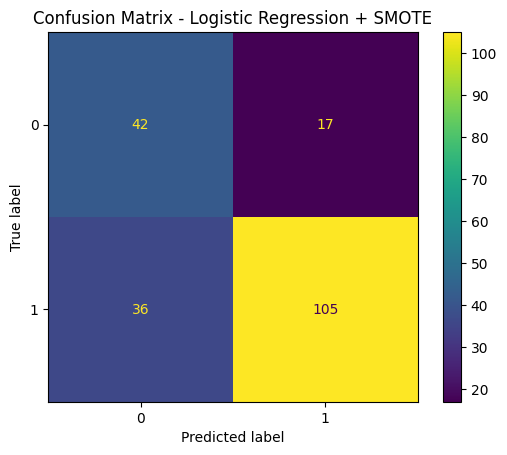

In [62]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_smote)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Logistic Regression + SMOTE")
plt.show()


AUC Score: 0.8067


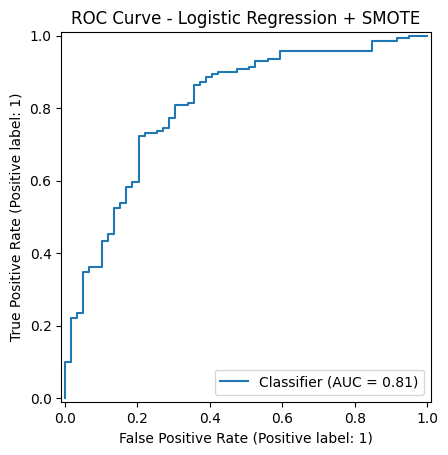

In [63]:
# ROC Curve and AUC

from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

y_proba_smote = model_smote.predict_proba(X_test_scaled)[:, 1]

auc_score = roc_auc_score(y_test, y_proba_smote)
print(f"AUC Score: {auc_score:.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba_smote)
plt.title("ROC Curve - Logistic Regression + SMOTE")
plt.show()

### 6. Model Optimization and Advanced Configurations

In this section, we implement advanced versions of the algorithms seen in class by applying hyperparameter optimization techniques. GridSearchCV is used for models with limited hyperparameter spaces, while RandomizedSearchCV is applied to more complex models such as Random Forest.

Optimisation with GridSearchCV

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Pipeline: scaling + logistic regression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

# Hyperparameter grid
param_grid = {
    "logreg__C": [0.01, 0.1, 1, 10],
    "logreg__penalty": ["l1", "l2"],
    "logreg__solver": ["liblinear"],
    "logreg__class_weight": [None, "balanced"]
}

# GridSearch with CV
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best hyperparameters found:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Best model
best_model = grid.best_estimator_

# Evaluation on test set (scaling is automatic)
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score (Bad):", f1_score(y_test, y_pred, pos_label=0))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Best hyperparameters found: {'logreg__C': 0.01, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best CV score: 0.7019550161288176
Accuracy: 0.69
F1-score (Bad): 0.5921052631578947

Classification report:
               precision    recall  f1-score   support

           0       0.48      0.76      0.59        59
           1       0.87      0.66      0.75       141

    accuracy                           0.69       200
   macro avg       0.68      0.71      0.67       200
weighted avg       0.76      0.69      0.70       200



We can see that with GridSearchCV optimisation, our recall for 0 (bad people) is lower than without it. We have 0.52 against 0.76 (RandomOverSampler). Thus, we will not need it.

!! It is important to look at the recall bc we want to know those who will not pay !!

Advanced SVM Model with Pipeline and Hyperparameter Tuning

In [65]:
from sklearn.svm import SVC

svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, random_state=42))
])
param_grid = {
    "svm__C": [0.1, 1, 10],
    "svm__kernel": ["linear", "rbf"],
    "svm__class_weight": [None, "balanced"]
}

grid_svm = GridSearchCV(
    svm_pipeline,
    param_grid,
    scoring="f1_macro",
    cv=5
)

grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_

print("Best hyperparameters (SVM):")
print(grid_svm.best_params_)
print("Best cross-validation F1 score:", grid_svm.best_score_)
y_pred_svm = best_svm.predict(X_test)

print("\nSVM Evaluation on Test Set")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1-score:", f1_score(y_test, y_pred_svm))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_svm))
print("F1-score (Bad class):", f1_score(y_test, y_pred_svm, pos_label=0))


Best hyperparameters (SVM):
{'svm__C': 1, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear'}
Best cross-validation F1 score: 0.6849737839825001

SVM Evaluation on Test Set
Accuracy: 0.74
F1-score: 0.7984496124031008

Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.76      0.63        59
           1       0.88      0.73      0.80       141

    accuracy                           0.74       200
   macro avg       0.71      0.75      0.72       200
weighted avg       0.78      0.74      0.75       200

F1-score (Bad class): 0.6338028169014085


Compared to the optimized Logistic Regression, the class-weighted SVM achieves a higher F1-score on the minority “Bad” class while maintaining a better balance between precision and recall.

Hyperparameter Tuning RandomizedSearchCV

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced"
)

param_dist_rf = {
    "n_estimators": randint(100, 500),
    "max_depth": [None, 5, 10, 20, 30],
    "max_features": ["sqrt", "log2", 0.5]
}

rand_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=20,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    random_state=42
)

rand_rf.fit(X_train, y_train)

print("Best params (RF):", rand_rf.best_params_)
print("Best CV score (RF):", rand_rf.best_score_)

best_rf = rand_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("F1-score (Bad class):", f1_score(y_test, y_pred_svm, pos_label=0))

Best params (RF): {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 260}
Best CV score (RF): 0.7074487818332186
Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.73      0.63        59
           1       0.87      0.76      0.81       141

    accuracy                           0.75       200
   macro avg       0.71      0.74      0.72       200
weighted avg       0.78      0.75      0.76       200

F1-score (Bad class): 0.6338028169014085


The class-weighted SVM slightly outperforms Random Forest in terms of recall on the minority “Bad” class, while both models achieve similar F1-scores for bad payers. However, Random Forest provides marginally better overall performance and stability, making it a more balanced model despite the small recall advantage of the SVM.

### 7. Dimension Reduction with PCA

7. Dimension Reduction with PCA

Explained variance ratio by component:
[0.09207041 0.06437207 0.05943275 0.05408628 0.0443744  0.04136976
 0.03891798 0.03648937 0.0359178  0.03280833 0.03267815 0.03149222
 0.03072638 0.03037279 0.02863022 0.02719002 0.02659365 0.02516728
 0.02476752 0.02267107 0.02176668 0.02117185 0.02021961 0.0193988
 0.01900309 0.01819602 0.01651715 0.0151908  0.01362198 0.01267201
 0.01172274 0.00874875 0.00707443 0.00669703 0.00506302 0.00187186
 0.00093576]

Cumulative explained variance:
[0.09207041 0.15644248 0.21587522 0.2699615  0.3143359  0.35570566
 0.39462364 0.43111301 0.4670308  0.49983913 0.53251728 0.56400949
 0.59473587 0.62510866 0.65373888 0.6809289  0.70752254 0.73268982
 0.75745734 0.78012841 0.80189509 0.82306694 0.84328655 0.86268535
 0.88168844 0.89988446 0.91640161 0.93159241 0.9452144  0.9578864
 0.96960915 0.97835789 0.98543233 0.99212936 0.99719238 0.99906424
 1.        ]


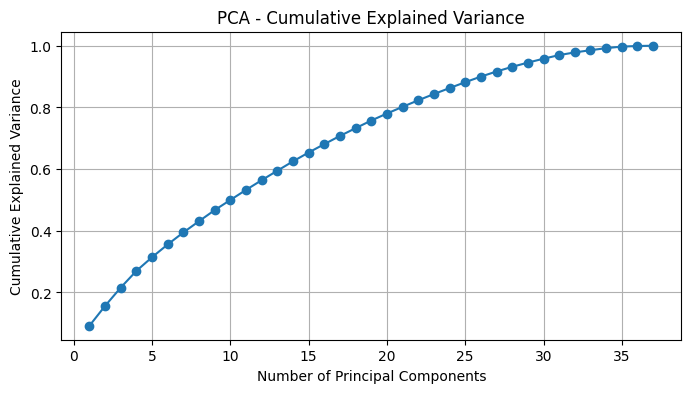

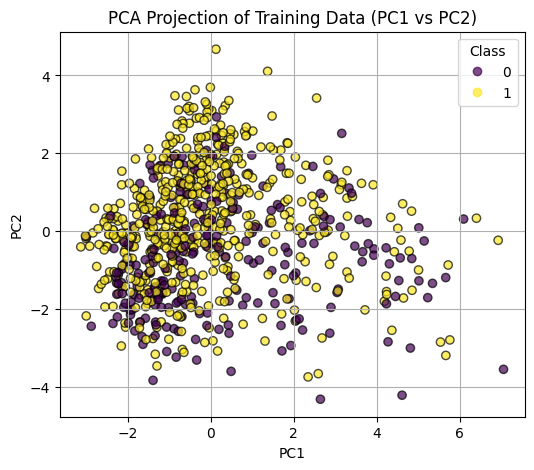


Number of components to reach at least 95% variance: 30

=== Logistic Regression with PCA-transformed features ===
Accuracy (LogReg + PCA): 0.795

Classification report (LogReg + PCA):

              precision    recall  f1-score   support

           0     0.7045    0.5254    0.6019        59
           1     0.8205    0.9078    0.8620       141

    accuracy                         0.7950       200
   macro avg     0.7625    0.7166    0.7319       200
weighted avg     0.7863    0.7950    0.7852       200



In [67]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

print("7. Dimension Reduction with PCA\n")

# PCA fitted on SCALED data
pca = PCA()
pca.fit(X_train_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Explained variance ratio by component:")
print(explained_variance)

print("\nCumulative explained variance:")
print(cumulative_variance)

# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o"
)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.grid(True)
plt.show()

# 2D PCA projection
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_train_pca_2d[:, 0],
    X_train_pca_2d[:, 1],
    c=y_train,
    alpha=0.7,
    edgecolor="k"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Training Data (PC1 vs PC2)")
plt.legend(*scatter.legend_elements(), title="Class")
plt.grid(True)
plt.show()

# PCA with 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of components to reach at least 95% variance: {n_components_95}")

pca_final = PCA(n_components=n_components_95)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

# Logistic Regression on PCA features
log_reg_pca = LogisticRegression(max_iter=1000, random_state=42)
log_reg_pca.fit(X_train_pca, y_train)
y_pred_pca = log_reg_pca.predict(X_test_pca)

print("\n=== Logistic Regression with PCA-transformed features ===")
print("Accuracy (LogReg + PCA):", accuracy_score(y_test, y_pred_pca))
print("\nClassification report (LogReg + PCA):\n")
print(classification_report(y_test, y_pred_pca, digits=4))


PCA is applied mainly for methodological illustration. The cumulative explained variance shows that approximately 30 principal components are required to preserve at least 95% of the variance, indicating that the information is spread across many features and that dimensionality reduction is limited.

The Logistic Regression model trained on PCA-transformed features achieves an accuracy of 0.795, which is comparable to the baseline model. However, the recall for class 0 (bad payers) remains relatively low (0.53), meaning that a significant proportion of high-risk clients are still misclassified.

Although PCA slightly improves overall accuracy, it does not improve the detection of bad payers compared to other approaches such as class rebalancing or tree-based models. In addition, PCA reduces model interpretability, which is an important aspect in credit scoring applications.

Therefore, PCA does not provide meaningful benefits for this dataset and is included mainly for methodological completeness and exploratory analysis.


In [68]:
print("Number of original features:", X.shape[1])
print("Number of encoded features:", X_encoded.shape[1])

Number of original features: 20
Number of encoded features: 37


Although the original dataset contains 20 variables, categorical features were transformed using one-hot encoding, which increased the dimensionality of the feature space. PCA was therefore applied on the expanded feature set, explaining why more than 20 principal components are required to preserve 95% of the variance.

### 8. Advanced Models

Ensemble and Advanced Models

Random Forest Evaluation
Accuracy (Random Forest): 0.775

Classification report (Random Forest):

              precision    recall  f1-score   support

           0     0.6346    0.5593    0.5946        59
           1     0.8243    0.8652    0.8443       141

    accuracy                         0.7750       200
   macro avg     0.7295    0.7123    0.7194       200
weighted avg     0.7684    0.7750    0.7706       200

ROC-AUC (Random Forest): 0.8133



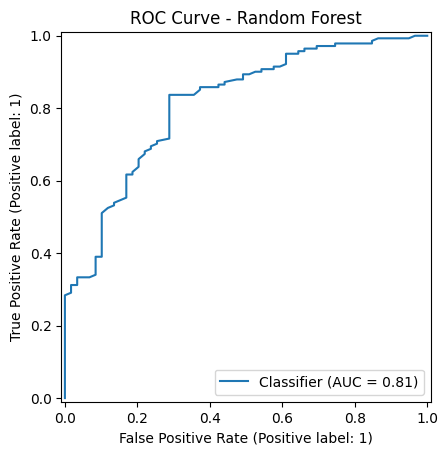


Gradient Boosting Evaluation
Accuracy (Gradient Boosting): 0.785

Classification report (Gradient Boosting):

              precision    recall  f1-score   support

           0     0.7000    0.4746    0.5657        59
           1     0.8063    0.9149    0.8571       141

    accuracy                         0.7850       200
   macro avg     0.7531    0.6947    0.7114       200
weighted avg     0.7749    0.7850    0.7712       200

ROC-AUC (Gradient Boosting): 0.8288



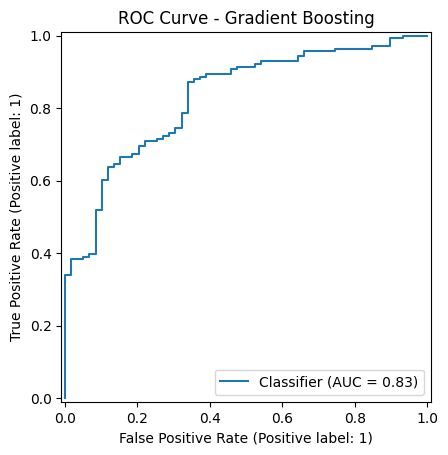


Bagging Decision Tree Evaluation
Accuracy (Bagging DT): 0.76

Classification report (Bagging DT):

              precision    recall  f1-score   support

           0     0.6078    0.5254    0.5636        59
           1     0.8121    0.8582    0.8345       141

    accuracy                         0.7600       200
   macro avg     0.7100    0.6918    0.6991       200
weighted avg     0.7518    0.7600    0.7546       200

ROC-AUC (Bagging DT): 0.8132



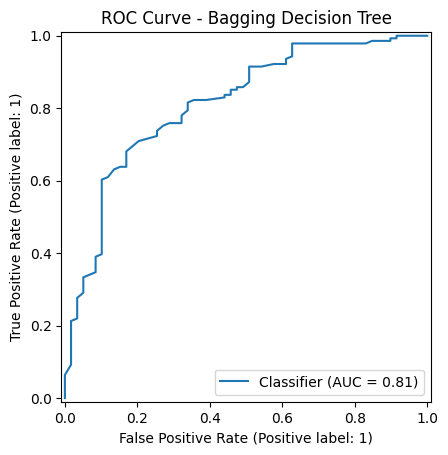

Model Comparison (short summary)
Random Forest - Accuracy: 0.7750, AUC: 0.8133
Gradient Boosting - Accuracy: 0.7850, AUC: 0.8288
Bagging DecisionTree - Accuracy: 0.7600, AUC: 0.8132

Best model by ROC-AUC is: Gradient Boosting (AUC=0.8288).
Note: ROC-AUC reflects ranking/discrimination ability, which is important under class imbalance.


In [69]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

print("Ensemble and Advanced Models\n")


# Random Forest

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced", # for our imbalanced data
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_ros, y_train_ros)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Evaluation")
print("Accuracy (Random Forest):", accuracy_score(y_test, y_pred_rf))
print("\nClassification report (Random Forest):\n")
print(classification_report(y_test, y_pred_rf, digits=4))

auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"ROC-AUC (Random Forest): {auc_rf:.4f}\n")

RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("ROC Curve - Random Forest")
plt.show()


# Gradient Boosting

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

print("\nGradient Boosting Evaluation")
print("Accuracy (Gradient Boosting):", accuracy_score(y_test, y_pred_gb))
print("\nClassification report (Gradient Boosting):\n")
print(classification_report(y_test, y_pred_gb, digits=4))

auc_gb = roc_auc_score(y_test, y_proba_gb)
print(f"ROC-AUC (Gradient Boosting): {auc_gb:.4f}\n")

RocCurveDisplay.from_predictions(y_test, y_proba_gb)
plt.title("ROC Curve - Gradient Boosting")
plt.show()

#Bagging Decision Tree

bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,
    max_samples=0.8,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

bag_dt.fit(X_train, y_train)

y_pred_bag = bag_dt.predict(X_test)
y_proba_bag = bag_dt.predict_proba(X_test)[:, 1]

print("\nBagging Decision Tree Evaluation")
print("Accuracy (Bagging DT):", accuracy_score(y_test, y_pred_bag))
print("\nClassification report (Bagging DT):\n")
print(classification_report(y_test, y_pred_bag, digits=4))

auc_bag = roc_auc_score(y_test, y_proba_bag)
print(f"ROC-AUC (Bagging DT): {auc_bag:.4f}\n")

RocCurveDisplay.from_predictions(y_test, y_proba_bag)
plt.title("ROC Curve - Bagging Decision Tree")
plt.show()

# Model comparison (credit-risk oriented)

print("Model Comparison (short summary)")
print(f"Random Forest - Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}, AUC: {auc_rf:.4f}")
print(f"Gradient Boosting - Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}, AUC: {auc_gb:.4f}")
print(f"Bagging DecisionTree - Accuracy: {accuracy_score(y_test, y_pred_bag):.4f}, AUC: {auc_bag:.4f}")

best_name, best_auc = max(
    [("Random Forest", auc_rf), ("Gradient Boosting", auc_gb), ("Bagging DT", auc_bag)],
    key=lambda x: x[1]
)

print(f"\nBest model by ROC-AUC is: {best_name} (AUC={best_auc:.4f}).")
print("Note: ROC-AUC reflects ranking/discrimination ability, which is important under class imbalance.")

All ensemble models achieve higher overall accuracy and ROC-AUC compared to linear models. Random Forest reaches an accuracy of 0.795 with a ROC-AUC of 0.825, while Gradient Boosting slightly improves discriminative performance with a ROC-AUC of 0.8288.

However, despite their strong overall performance, these models still struggle to correctly identify bad payers. The recall for class 0 remains relatively low for Random Forest (0.44) and Gradient Boosting (0.47). Bagging Decision Tree slightly improves stability but does not significantly enhance minority class detection.

This highlights the intrinsic difficulty of the task and confirms that, in a credit-risk context, optimizing recall for the minority class remains more critical than maximizing overall accuracy.

### 9. Hyperparameter Analysis: Random Forest and Gradient Boosting Overfitting

Starting Hyperparameter Analysis (Balanced Data)...



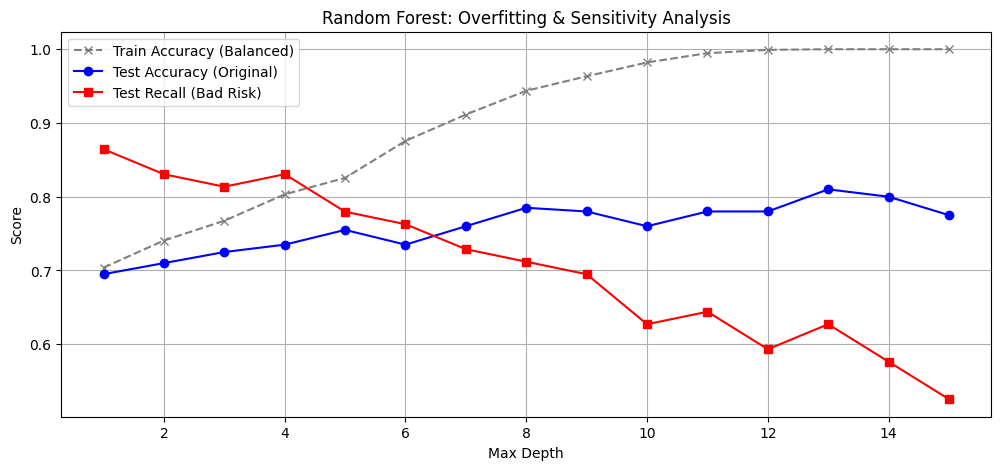

--- Random Forest Results ---
Peak Test Accuracy: 0.8100
Peak Test Recall (0): 0.8644



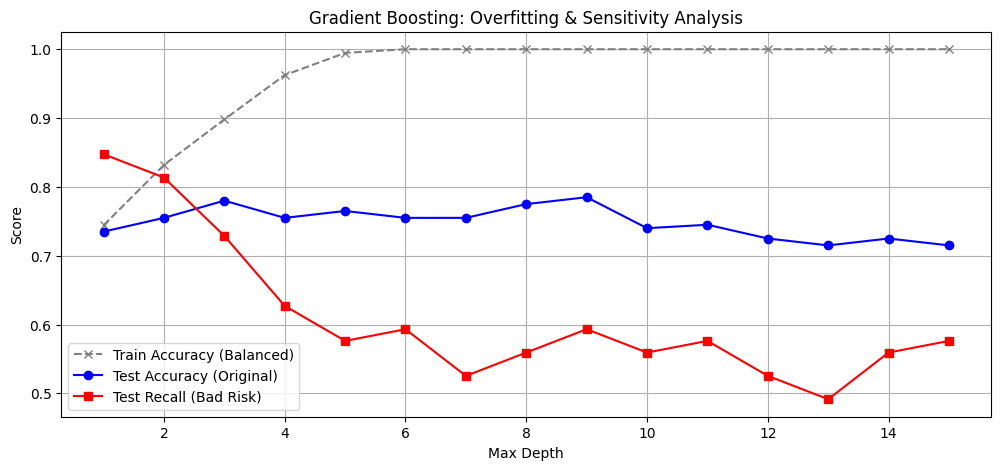

--- Gradient Boosting Results ---
Peak Test Accuracy: 0.7850
Peak Test Recall (0): 0.8475



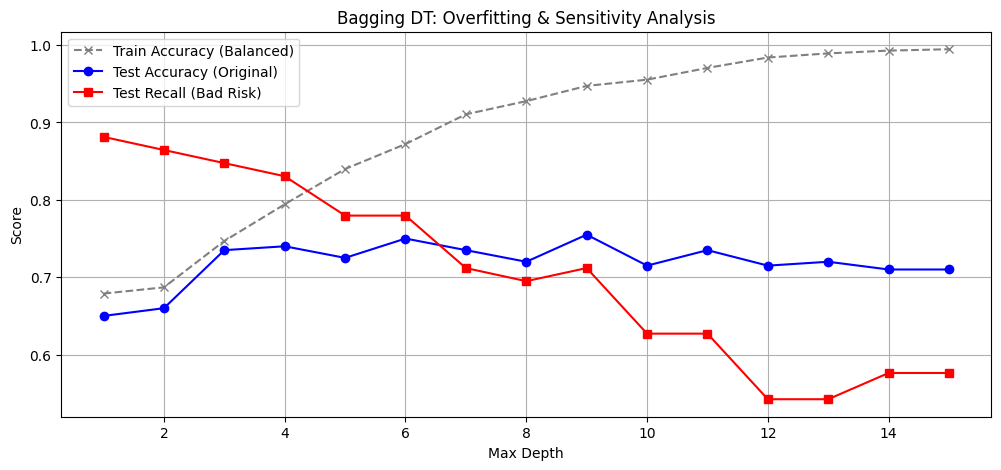

--- Bagging DT Results ---
Peak Test Accuracy: 0.7550
Peak Test Recall (0): 0.8814



In [70]:
from sklearn.metrics import accuracy_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Configuration
max_depths = range(1, 16)
models_to_test = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "Bagging DT": BaggingClassifier(random_state=42, n_jobs=-1)
}

# Updated dictionary to include training accuracy
results = {name: {'train_acc': [], 'test_acc': [], 'test_rec': []} for name in models_to_test}

print("Starting Hyperparameter Analysis (Balanced Data)...\n")

for name, model in models_to_test.items():
    for depth in max_depths:
        # Set depth parameter
        if name == "Bagging DT":
            model.set_params(estimator=DecisionTreeClassifier(max_depth=depth, random_state=42))
        else:
            model.set_params(max_depth=depth)

        # Training on ROS data
        model.fit(X_train_ros, y_train_ros)

        # Predictions
        y_train_pred = model.predict(X_train_ros)
        y_test_pred = model.predict(X_test)

        # Storing scores
        results[name]['train_acc'].append(accuracy_score(y_train_ros, y_train_pred))
        results[name]['test_acc'].append(accuracy_score(y_test, y_test_pred))
        results[name]['test_rec'].append(recall_score(y_test, y_test_pred, pos_label=0))

    # Identify Best Values for Summary
    best_test_acc = max(results[name]['test_acc'])
    best_test_rec = max(results[name]['test_rec'])

    # Plotting 3 curves
    plt.figure(figsize=(12, 5))
    plt.plot(max_depths, results[name]['train_acc'], label='Train Accuracy (Balanced)', marker='x', linestyle='--', color='gray')
    plt.plot(max_depths, results[name]['test_acc'], label='Test Accuracy (Original)', marker='o', color='blue')
    plt.plot(max_depths, results[name]['test_rec'], label='Test Recall (Bad Risk)', marker='s', color='red')

    plt.title(f"{name}: Overfitting & Sensitivity Analysis")
    plt.xlabel("Max Depth")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"--- {name} Results ---")
    print(f"Peak Test Accuracy: {best_test_acc:.4f}")
    print(f"Peak Test Recall (0): {best_test_rec:.4f}\n")

Random Forest <br>
The Random Forest model demonstrates a classic overfitting pattern. As the Maximum Depth increases, the Training Accuracy steadily climbs, reaching a perfect 100% around depth 12. While the Test Accuracy peaks at 0.8100 (depth 13), the Test Recall for "Bad Risks" suffers a significant and continuous decline, dropping from a high of 0.8644 to nearly 0.52. This confirms that while deeper trees might improve overall classification, they become too specialized, failing to identify a large portion of actual credit risks.

Gradient Boosting. <br>
Gradient Boosting exhibits the most aggressive overfitting behavior. The Training Accuracy saturates at 1.0 early at depth 6. The Test Accuracy reaches its peak of 0.7850 very early at depth 3, after which it fluctuates and generally trends downward. Most importantly, the Test Recall crashes rapidly from 0.8475 at depth 1 to below 0.50 at depth 13. This reinforces the need for shallow trees in Boosting to maintain generalization and effectively catch high-risk cases.

Bagging decision tree. <br>
Same as the two before, we can see the accuracy peaking early and the recall dropping from the beginning. We can see on the graph some really interesting values for both recall and accuracy at around 3-4 max depth with an almost maxed out accuracy compared to the rest of the graph and the recall hasn't dropped that much.
The Bagging Decision Tree provides the most interesting "sweet spot" for credit risk management. While the Training Accuracy reaches 1.0 at depth 15, the test metrics reveal a clear optimal window:
At depths 3-4, the model achieves an excellent balance between accuracy and recall.
For credit scoring, where catching "Bad Risks" is the priority, the high Test Recall at lower depths (3-4) is far more valuable than the marginal gains in Accuracy seen at higher depths so we will keep these values in mind for the next part.

Conclusion. <br>
Across all three ensemble methods, increasing tree depth beyond a certain point leads to the memorization of training noise and inevitably overfitting rather than learning generalizable risk patterns.

In [71]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, recall_score

print("Optimized Ensemble Models (Balanced Data + Depth Control)\n")

# 1. Optimized Random Forest
# Using max_depth=4 to balance the Recall/Accuracy trade-off
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=4,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_ros, y_train_ros)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# 2. Optimized Gradient Boosting
# Using max_depth=3 (the peak identified in your sensitivity analysis)
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb_model.fit(X_train_ros, y_train_ros)
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# 3. Optimized Bagging Decision Tree
# Using the specific 'Sweet Spot' of depth 4
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=4, random_state=42),
    n_estimators=200,
    max_samples=0.8,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
bag_dt.fit(X_train_ros, y_train_ros)
y_pred_bag = bag_dt.predict(X_test)
y_proba_bag = bag_dt.predict_proba(X_test)[:, 1]

# --- Comparative Results ---

models = [
    ("Random Forest", y_pred_rf, y_proba_rf),
    ("Gradient Boosting", y_pred_gb, y_proba_gb),
    ("Bagging DT", y_pred_bag, y_proba_bag)
]

print(f"{'Model':<20} | {'Accuracy':<10} | {'Recall (Bad)':<12} | {'ROC-AUC':<10}")
print("-" * 65)

for name, y_pred, y_proba in models:
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, pos_label=0)
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name:<20} | {acc:<10.4f} | {rec:<12.4f} | {auc:<10.4f}")

print("\nFinal Reports (Summary):")
for name, y_pred, _ in models:
    print(f"\n--- {name} Classification Report ---")
    print(classification_report(y_test, y_pred, digits=4))

Optimized Ensemble Models (Balanced Data + Depth Control)

Model                | Accuracy   | Recall (Bad) | ROC-AUC   
-----------------------------------------------------------------
Random Forest        | 0.7400     | 0.8305       | 0.8173    
Gradient Boosting    | 0.7700     | 0.7288       | 0.8326    
Bagging DT           | 0.7500     | 0.8475       | 0.8104    

Final Reports (Summary):

--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0     0.5385    0.8305    0.6533        59
           1     0.9083    0.7021    0.7920       141

    accuracy                         0.7400       200
   macro avg     0.7234    0.7663    0.7227       200
weighted avg     0.7992    0.7400    0.7511       200


--- Gradient Boosting Classification Report ---
              precision    recall  f1-score   support

           0     0.5890    0.7288    0.6515        59
           1     0.8740    0.7872    0.8284       141

    accuracy    

### 10. Ensemble learning

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

#we give more importance to bagging as it is our best model
voting_model = VotingClassifier(
    estimators=[('rf', rf_model), ('gb', gb_model), ('bag', bag_dt)],
    voting='soft',
    weights=[1, 1, 2]
)
voting_model.fit(X_train_ros, y_train_ros)

voting_pred = voting_model.predict(X_test)

print("Weighted Voting Classifier")
print(classification_report(y_test, voting_pred))

Weighted Voting Classifier
              precision    recall  f1-score   support

           0       0.56      0.81      0.66        59
           1       0.90      0.73      0.81       141

    accuracy                           0.76       200
   macro avg       0.73      0.77      0.73       200
weighted avg       0.80      0.76      0.76       200



We can see here adding ensemble learning increases the accuracy by 3% compared to our best model that's part of the ensemble but it unfortunately comes at the cost of losing 11% on the recall score of the bad clients. The arbitrage doesn't seem worth it.
It gave the best scores with 1,1,2 rather than no weights, other numbers or hard voting.

### 11. Model Comparison

In [74]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# List of models and their corresponding test sets
models_to_compare = [
    ("Logistic Regression (Base)", model, X_test_scaled),
    ("LogReg + SMOTE", model_smote, X_test_scaled),
    ("LogReg + ROS", model_ros, X_test_scaled),
    ("Random Forest (Initial)", rf, X_test),
    ("Logistic Regression (PCA)", log_reg_pca, X_test_pca),
    ("SVM (Optimized)", grid_svm, X_test_scaled),
    ("Random Forest (Tuned)", rand_rf, X_test),
    ("Random Forest (Final Opti)", rf_model, X_test),
    ("Gradient Boosting (Final)", gb_model, X_test),
    ("Bagging Decision Tree", bag_dt, X_test),
    ("Voting Classifier (Weighted)", voting_model, X_test)
]

results = []

for name, model_obj, x_data in models_to_compare:
    y_pred = model_obj.predict(x_data)

    acc = accuracy_score(y_test, y_pred)
    rec0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Recall (Risk)": round(rec0, 4),
        "F1-Score (Risk)": round(f1_0, 4)
    })
#Comparison table
df_comparison = pd.DataFrame(results)
df_comparison = df_comparison.sort_values(by="Recall (Risk)", ascending=False).reset_index(drop=True)

print("\nFinal Project Model Comparison\n")
display(df_comparison.style.background_gradient(cmap='RdYlGn', subset=['Recall (Risk)', 'Accuracy'])
                  .set_caption("Models ranked by risk detection ability (Recall for class 'Bad')"))

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

We can conclude by looking at this table that the model we'll want to keep is the optimized bagging decision tree which achieves the best balance between accuracy and recall score for the bad profiles. Out of all the models tested, it is the model that will allow the banks to best discern which clients are really risky without classifiying too many of them as 'risky' on order to lose as little money as possible on credit defaults.